In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
load_dotenv()

WD = os.getenv('working_directory')

2025-01-12 19:49:16.260306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-12 19:49:16.484519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-01-12 19:49:16.484549: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-01-12 19:49:16.533900: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-12 19:49:17.525798: W tensorflow/stream_executor/pla

# TENSORFLOW

## CLOSE PRICE SEULEMENT, en 1d (Daily)

### PRE PROCESSING

In [40]:
# fonctions communes aux différents modèles
def load_data(name):
    """
    Load un dataframe depuis un fichier csv data/name.csv
    """
    return pd.read_csv(f'{WD}/data/{name}.csv') 

def get_date(df):
    return df['Open_time'].copy()

def df_to_numpy(df):
    return df.to_numpy()

def train_test_val(X, y, date, train_size):
    """
    """
    q_train_size = int(len(X)*train_size)
    q_val_test_size = int(len(X)*(train_size+(1-train_size)/2))

    X_train, y_train = X[:q_train_size], y[:q_train_size]
    X_val, y_val = X[q_train_size:q_val_test_size], y[q_train_size:q_val_test_size]
    X_test, y_test = X[q_val_test_size:], y[q_val_test_size:]

    date_numpy = df_to_numpy(date)
    date_train, date_val, date_test = date_numpy[:q_train_size], date_numpy[q_train_size:q_val_test_size], date_numpy[q_val_test_size:]
    return date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test

def main_pre_processing(name, is_one_var):
    """
    Renvoie X_train, y_train, X_val, y_val, X_test, y_test pour le df
    """
    df = load_data(name)
    date = get_date(df)
    if is_one_var:
        df = get_close_price(df)
        X, y, scaler_features, scaler_target = build_window_matrix_one_var(df, window_size=WINDOW_SIZE)
    else:
        df = rearrange_data(df)
        X, y, scaler_features, scaler_target = build_window_matrix_multi_var(df, window_size=WINDOW_SIZE)
    return train_test_val(X, y, date, train_size=0.8), scaler_features, scaler_target

In [6]:
## Fonctions propres au modèle pour 1 seule variable Close_price
def get_close_price(df):
    """
    Extrait seulement le prix de cloture de la journée
    """
    return df['Close_price'].copy()

def build_window_matrix_one_var(df, window_size):
    """
    """
    scaler = MinMaxScaler()

    df_numpy = df_to_numpy(df).reshape(len(df), -1)
    df_numpy_scaled = scaler.fit_transform(df_numpy)
    
    X = []
    y = []
    for i in range(len(df_numpy_scaled)-window_size):
        row = [a for a in df_numpy_scaled[i:i+window_size]]
        X.append(row)
        y.append(df_numpy_scaled[i+window_size])

    return np.array(X).astype(np.float32), np.array(y).astype(np.float32), scaler, scaler

#### Pre processing du dataframe dataset_raw_1d

In [7]:
data_name = "dataset_raw_1d"
is_one_var = True
WINDOW_SIZE = 7
(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')


X_train : (394, 7, 1)
y_train : (394, 1)
X_val : (49, 7, 1)
y_val : (49, 1)
X_test : (50, 7, 1)
y_test : (50, 1)


Format de X_train : 394 observations, 7 jours de données glissante, 1 variable Close_price

Format de y_train : 394 observations, 1 variable Close_price pour le (WINDOW_SIZE+1 : 8ème jour)

### TRAINING

In [8]:
## Fonctions communes aux différents modèles pour l'entrainement
def prepare_model(name, n_features):
    """
    Set up le model
    """
    model = Sequential([Input((WINDOW_SIZE, n_features)),
                        LSTM(64),
                        Dense(32, activation='relu'),
                        Dense(32, activation='relu'),
                        Dense(1)
                        ], name=name)
    
    # model = Sequential([Input((WINDOW_SIZE, n_features)),
    #                     LSTM(64),
    #                     Dense(32, activation='relu'),
    #                     Dense(32, activation='relu'),
    #                     Dense(32, activation='relu'),
    #                     Dense(1)
    #                     ], name=name)
    
    return model

def prepare_checkpoint(name):
    """
    """
    return ModelCheckpoint(f'{WD}/src/model/models/{name}/', save_best_only=True, save_format='tf', monitor='loss')

def train(model, learning_rate):
    """
    """
    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])
    return model

def fit(model, cp, X_train, y_train, X_val, y_val, N_EPOCHS):
    """
    """
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=N_EPOCHS, callbacks=[cp])
    return model

def main_training_model(model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS):

    cp = prepare_checkpoint(name=model_name)
    model = prepare_model(name=model_name,n_features=X_train.shape[2])
    model = train(model, 0.001)
    model = fit(model, cp, X_train, y_train, X_val, y_val, N_EPOCHS)

#### Training du modèle Close_price-dataset_raw_1d-100

In [9]:
N_EPOCHS = 100
model_name = "Close_price"
data_name = "dataset_raw_1d"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

#main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

### ANALYSE DES RÉSULTATS

In [44]:
# Fonctions communes aux différentes modèles
def create_directory_if_not_exists(directory_name):
    """
    Crée un répertoire s'il n'existe pas déjà.

    Parameters:
    directory_name (str): Le nom du répertoire à créer.
    """
    if not os.path.exists(directory_name):
        try:
            os.makedirs(directory_name)
            print(f"Répertoire '{directory_name}' créé avec succès.")
        except Exception as e:
            print(f"Erreur lors de la création du répertoire '{directory_name}': {e}")
    else:
        print(f"Le répertoire '{directory_name}' existe déjà.")


def load(name):
    """
    """
    return load_model(f'{WD}/src/model/models/{name}/', custom_objects={'LSTM': LSTM})

def predict(model, X):
    """
    """
    return model.predict(X)

def inverse_scaler(scaler, array):
    """
    """
    return scaler.inverse_transform(array)

def plot(df, model_name, is_train):
    """
    """
    ticks_to_display = np.linspace(0, len(df) - 1, 5, dtype=int)  # 5 indices répartis uniformément
    create_directory_if_not_exists(f'{WD}/figure/{model_name}')
    plt.clf()
    plt.plot(df['Date'], df['Actual N+1'], label='Actuals') 
    plt.plot(df['Date'], df['Predictions N+1'], label='Predictions')
    plt.xticks(ticks_to_display, df["Date"].iloc[ticks_to_display], rotation=45)
    plt.title(f"Comparaison Réel et Prédiction pour le jeu de {'train' if is_train==1 else 'test' if is_train==0 else 'validation'}")
    plt.legend()
    plt.savefig(f"{WD}/figure/{model_name}/COMPARAISON_{'train_' if is_train==1 else 'test_' if is_train==0 else 'val_'}prediction.png")
    plt.show()

In [45]:
## Fonctions propres au modèle pour 1 seule variable Close_price en Daily
def analyze(date, X, y, predictions):
    """
    """
    df_analyze = pd.concat([
                            pd.DataFrame(date), 
                            pd.DataFrame(X[:, WINDOW_SIZE-1, 0]), 
                            pd.DataFrame(y.reshape(-1)), 
                            pd.DataFrame(predictions)
                            ], axis=1)



    df_analyze.columns = ['Date', 'Actual N', 'Actual N+1', 'Predictions N+1']

    df_analyze['Actual UP or DOWN'] = pd.DataFrame((df_analyze['Actual N+1'] > df_analyze['Actual N']).astype(int))
    df_analyze['Predicted UP or DOWN'] = pd.DataFrame((df_analyze['Predictions N+1'] > df_analyze['Actual N']).astype(int))

    cm = confusion_matrix(df_analyze['Actual UP or DOWN'], df_analyze['Predicted UP or DOWN'])
    acc = cm[0][0] + cm[1][1]
    tot = cm.sum()
    print(f'Accuracy : {acc/tot*100}%')
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    
    return df_analyze, cm_df

def analyze_for_data(model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train):

    if is_train==1:
        date = date_train
        X = X_train
        y = y_train
    elif is_train==0:
        date = date_test
        X = X_test
        y = y_test
    else :
        date = date_val
        X = X_val
        y = y_val

    pred = predict(model, X)
    X_reshape = X.reshape(X.shape[0], -1)
    X_inv_scaled = inverse_scaler(scaler_features, X_reshape)
    X_inv_scaled = np.array(X_inv_scaled)
    X = X_inv_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])
    print("X_shape :", X.shape)
    #y = inverse_scaler(scaler_target, [y])
    y = inverse_scaler(scaler_target, y)
    print("y_shape :",y.shape)
    predictions = inverse_scaler(scaler_target, pred)

    df_analyze, cm_df = analyze(date, X, y, predictions)
    print(f"#####{'TRAIN' if is_train==1 else 'TEST' if is_train==0 else 'VAL'}#####\n",df_analyze.head(15).to_string())
    print(f'######MATRICE DE CONFUSION#######\n {cm_df}')
    plot(df_analyze, model.name, is_train)

def main_analyze_model(is_train):
    model_name = "Close_price-dataset_raw_1d-100"
    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    (date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var=True)

    analyze_for_data(loaded_model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train)

#### Analyse du modèle Close_price-dataset_raw_1d-100

2025-01-12 19:49:19.049809: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2025-01-12 19:49:19.049852: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-01-12 19:49:19.049882: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (margaux): /proc/driver/nvidia/version does not exist
2025-01-12 19:49:19.050236: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


13/13 [==============================] - 1s 4ms/step
X_shape : (394, 7, 1)
y_shape : (394, 1)
Accuracy : 55.32994923857868%
#####TRAIN#####
           Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2023-08-28  25971.208984  25826.019531     26025.296875                  0                     1
1   2023-08-29  25826.019531  25792.099609     25929.513672                  0                     1
2   2023-08-30  25792.099609  25759.949219     25958.482422                  0                     1
3   2023-08-31  25759.949219  26255.001953     25997.339844                  1                     1
4   2023-09-01  26255.001953  25910.500000     26149.066406                  0                     0
5   2023-09-02  25910.500000  25901.609375     26127.628906                  0                     1
6   2023-09-03  25901.609375  25841.609375     26106.705078                  0                     1
7   2023-09-04  25841.609375  25162.519531     2607

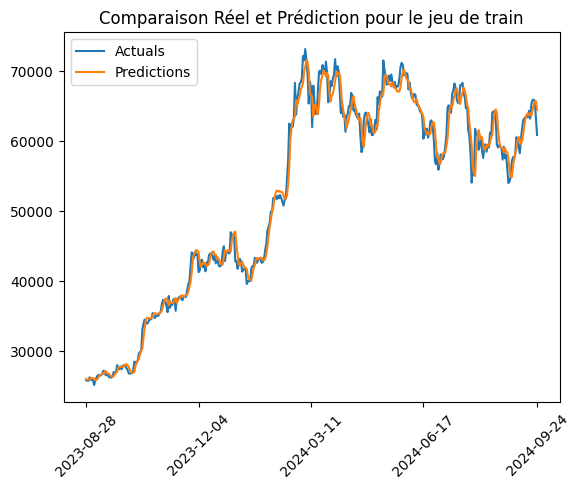

2/2 [==============================] - 1s 6ms/step
X_shape : (49, 7, 1)
y_shape : (49, 1)
Accuracy : 40.816326530612244%
#####VAL#####
           Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-09-25  60805.781250  60649.277344     62328.250000                  0                     1
1   2024-09-26  60649.277344  60752.710938     60931.855469                  1                     1
2   2024-09-27  60752.710938  62086.000000     60397.722656                  1                     0
3   2024-09-28  62086.000000  62058.000000     61012.953125                  0                     0
4   2024-09-29  62058.000000  62819.910156     61604.578125                  1                     0
5   2024-09-30  62819.910156  62224.000000     62482.972656                  0                     0
6   2024-10-01  62224.000000  62160.492188     62652.738281                  0                     1
7   2024-10-02  62160.492188  60636.019531     62538.578

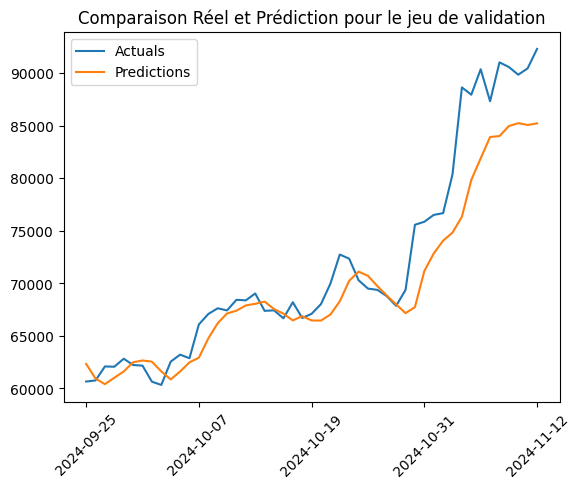

2/2 [==============================] - 1s 6ms/step
X_shape : (50, 7, 1)
y_shape : (50, 1)
Accuracy : 50.877192982456144%
#####TEST#####
           Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-11-13  92310.789062  94286.554688     85869.257812                  1                     0
1   2024-11-14  94286.554688  98317.117188     86969.781250                  1                     0
2   2024-11-15  98317.117188  98891.992188     88894.445312                  1                     0
3   2024-11-16  98891.992188  97672.398438     90349.617188                  0                     0
4   2024-11-17  97672.398438  97900.031250     90748.460938                  1                     0
5   2024-11-18  97900.031250  93010.007812     90864.515625                  0                     0
6   2024-11-19  93010.007812  91965.164062     89174.046875                  0                     0
7   2024-11-20  91965.164062  95863.109375     87113.16

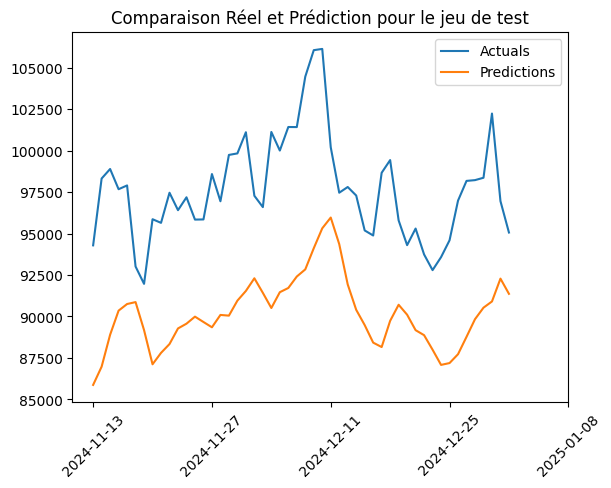

In [12]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train)

## CLOSE PRICE SEULEMENT, en 6h (6 heures)

#### Pre processing du dataframe dataset_raw_6h

In [46]:
data_name = "dataset_raw_6h"
# is_one_var = True car une seule variable
is_one_var = True
#On passe la window de 7 à 7*4=28 pour garder une semaine de fenêtre 
WINDOW_SIZE = 28

(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (1577, 28, 1)
y_train : (1577, 1)
X_val : (197, 28, 1)
y_val : (197, 1)
X_test : (198, 28, 1)
y_test : (198, 1)


#### Training du modèle Close_price-dataset_raw_6h-100

In [47]:
N_EPOCHS = 100
model_name = "Close_price"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

#main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

#### Analyse du modèle Close_price-dataset_raw_6h-100

In [48]:
def analyze(date, X, y, predictions):
    """
    """
    df_analyze = pd.concat([
                            pd.DataFrame(date), 
                            pd.DataFrame(X[:, WINDOW_SIZE-1, 0]), 
                            pd.DataFrame(y.reshape(-1)), 
                            pd.DataFrame(predictions)
                            ], axis=1)
    
    df_analyze.columns = ['Date', 'Actual N', 'Actual N+1', 'Predictions N+1']
    df_analyze_minuit = df_analyze
    #df_analyze_minuit = df_analyze[pd.to_datetime(df_analyze['Date']).dt.time == pd.Timestamp('00:00:00').time()]

    df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
    df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))

    cm = confusion_matrix(df_analyze_minuit['Actual UP or DOWN'], df_analyze_minuit['Predicted UP or DOWN'])
    acc = cm[0][0] + cm[1][1]
    tot = cm.sum()
    print(f'Accuracy : {acc/tot*100}%')
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    
    return df_analyze_minuit, cm_df

def main_analyze_model(is_train, model_name):
    #model_name = "Close_price-dataset_raw_6h-100"
    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    (date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var=True)

    analyze_for_data(loaded_model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train)

50/50 [==============================] - 1s 9ms/step
X_shape : (1577, 28, 1)
y_shape : (1577, 1)
Accuracy : 53.83639822447685%
#####TRAIN#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2023-08-28 00:00:00  25971.208984  25934.439453     25975.400391                  0                     1
1   2023-08-28 06:00:00  25934.439453  25892.490234     25978.019531                  0                     1
2   2023-08-28 12:00:00  25892.490234  25907.480469     25961.318359                  1                     1
3   2023-08-28 18:00:00  25907.480469  25826.021484     25954.902344                  0                     1
4   2023-08-29 00:00:00  25826.021484  25733.310547     25920.068359                  0                     1
5   2023-08-29 06:00:00  25733.310547  25783.681641     25869.019531                  1                     1
6   2023-08-29 12:00:00  25783.681641  25749.080078     25859.302734                  

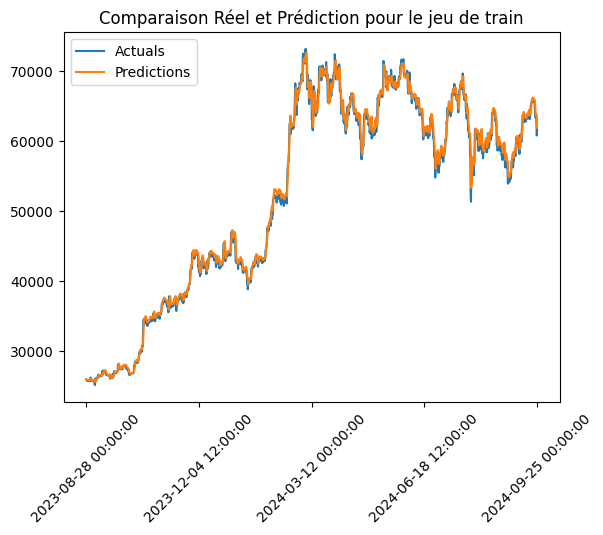

7/7 [==============================] - 1s 9ms/step
X_shape : (197, 28, 1)
y_shape : (197, 1)
Accuracy : 54.314720812182735%
#####VAL#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-09-25 06:00:00  61489.710938  61164.011719     61696.496094                  0                     1
1   2024-09-25 12:00:00  61164.011719  61628.011719     61470.746094                  1                     1
2   2024-09-25 18:00:00  61628.011719  60649.281250     61650.460938                  0                     1
3   2024-09-26 00:00:00  60649.281250  61176.011719     61292.011719                  1                     1
4   2024-09-26 06:00:00  61176.011719  60764.742188     61398.257812                  0                     1
5   2024-09-26 12:00:00  60764.742188  60632.000000     61278.867188                  0                     1
6   2024-09-26 18:00:00  60632.000000  60752.714844     61163.214844                  1    

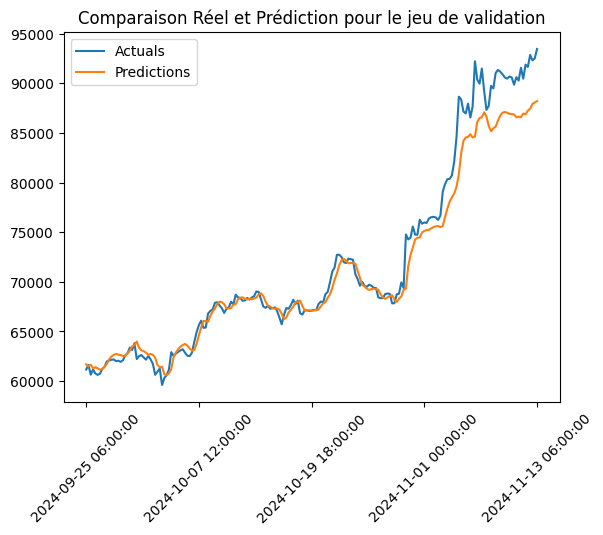

7/7 [==============================] - 1s 10ms/step
X_shape : (198, 28, 1)
y_shape : (198, 1)
Accuracy : 54.424778761061944%
#####TEST#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-11-13 12:00:00  93454.656250  93916.335938     88582.273438                  1                     0
1   2024-11-13 18:00:00  93916.335938  94286.562500     88965.062500                  1                     0
2   2024-11-14 00:00:00  94286.562500  97328.000000     89318.031250                  1                     0
3   2024-11-14 06:00:00  97328.000000  97974.992188     90507.554688                  1                     0
4   2024-11-14 12:00:00  97974.992188  98048.656250     91493.070312                  1                     0
5   2024-11-14 18:00:00  98048.656250  98317.125000     92122.851562                  1                     0
6   2024-11-15 00:00:00  98317.125000  98790.968750     92561.679688                  1  

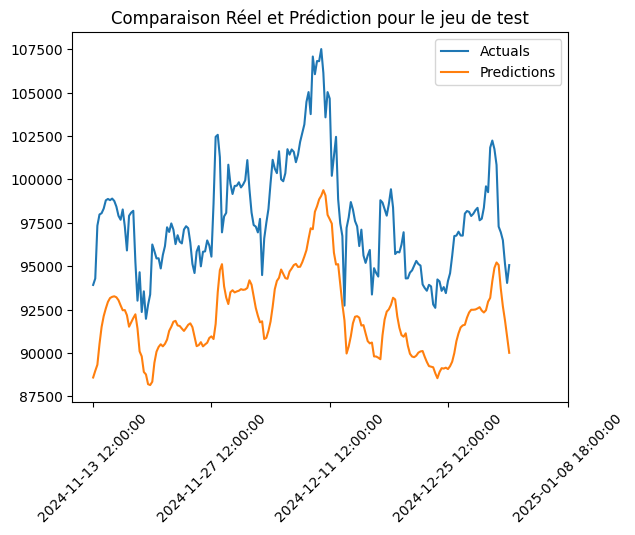

In [50]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train, full_model_name)

## CLOSE PRICE SEULEMENT, en 1h (1 heure)

#### Pre processing du dataframe dataset_raw_1h

In [51]:
data_name = "dataset_raw_1h"
# is_one_var = True car une seule variable
is_one_var = True
#On passe la window de 7 à 7*4=28 pour garder une semaine de fenêtre 
WINDOW_SIZE = 7*4*6

(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (9465, 168, 1)
y_train : (9465, 1)
X_val : (1183, 168, 1)
y_val : (1183, 1)
X_test : (1184, 168, 1)
y_test : (1184, 1)


#### Training du modèle Close_price-dataset_raw_1h-10

In [52]:
N_EPOCHS = 10
model_name = "Close_price"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

#main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

#### Analyse du modèle Close_price-dataset_raw_1h-10

296/296 [==============================] - 12s 40ms/step
X_shape : (9465, 168, 1)
y_shape : (9465, 1)
Accuracy : 53.312202852614895%
#####TRAIN#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2023-08-28 00:00:00  25971.208984  25910.089844     26005.572266                  0                     1
1   2023-08-28 01:00:00  25910.089844  25908.490234     25994.892578                  0                     1
2   2023-08-28 02:00:00  25908.490234  25983.160156     25984.324219                  1                     1
3   2023-08-28 03:00:00  25983.160156  25987.558594     25991.412109                  1                     1
4   2023-08-28 04:00:00  25987.558594  25982.640625     25998.941406                  0                     1
5   2023-08-28 05:00:00  25982.640625  25934.441406     26004.457031                  0                     1
6   2023-08-28 06:00:00  25934.441406  25967.480469     25998.349609            

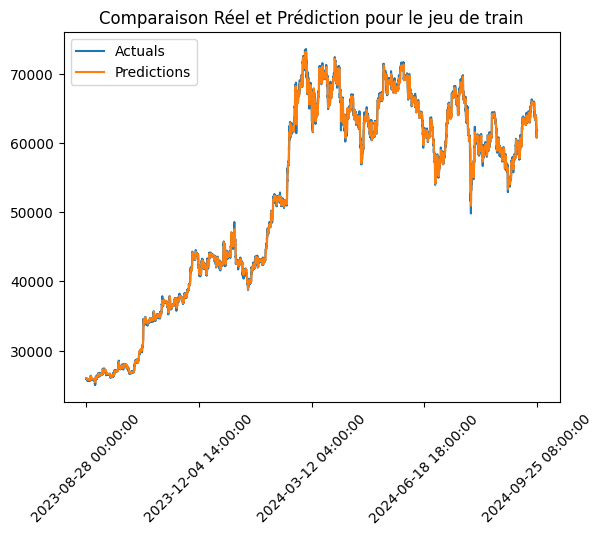

37/37 [==============================] - 2s 39ms/step
X_shape : (1183, 168, 1)
y_shape : (1183, 1)
Accuracy : 49.53508030431107%
#####VAL#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-09-25 09:00:00  61806.007812  61271.250000     61677.050781                  0                     0
1   2024-09-25 10:00:00  61271.250000  61188.281250     61567.578125                  0                     1
2   2024-09-25 11:00:00  61188.281250  61164.011719     61442.074219                  0                     1
3   2024-09-25 12:00:00  61164.011719  60798.800781     61329.070312                  0                     1
4   2024-09-25 13:00:00  60798.800781  61350.000000     61128.812500                  1                     1
5   2024-09-25 14:00:00  61350.000000  61077.781250     61138.289062                  0                     0
6   2024-09-25 15:00:00  61077.781250  61874.011719     61076.875000                  

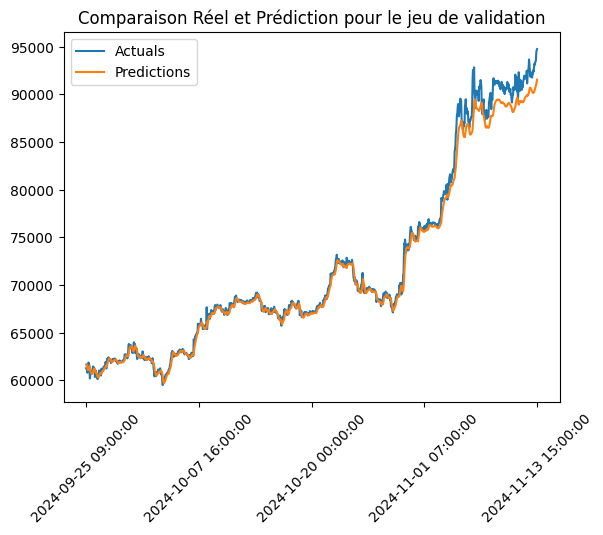

37/37 [==============================] - 3s 40ms/step
X_shape : (1184, 168, 1)
y_shape : (1184, 1)
Accuracy : 55.399408284023664%
#####TEST#####
                    Date      Actual N    Actual N+1  Predictions N+1  Actual UP or DOWN  Predicted UP or DOWN
0   2024-11-13 16:00:00  94739.968750  94048.000000     91759.421875                  0                     0
1   2024-11-13 17:00:00  94048.000000  93916.343750     91853.203125                  0                     0
2   2024-11-13 18:00:00  93916.343750  93684.000000     91885.273438                  0                     0
3   2024-11-13 19:00:00  93684.000000  94000.000000     91853.203125                  1                     0
4   2024-11-13 20:00:00  94000.000000  94271.992188     91847.773438                  1                     0
5   2024-11-13 21:00:00  94271.992188  94365.921875     91876.750000                  1                     0
6   2024-11-13 22:00:00  94365.921875  94160.546875     91919.507812                

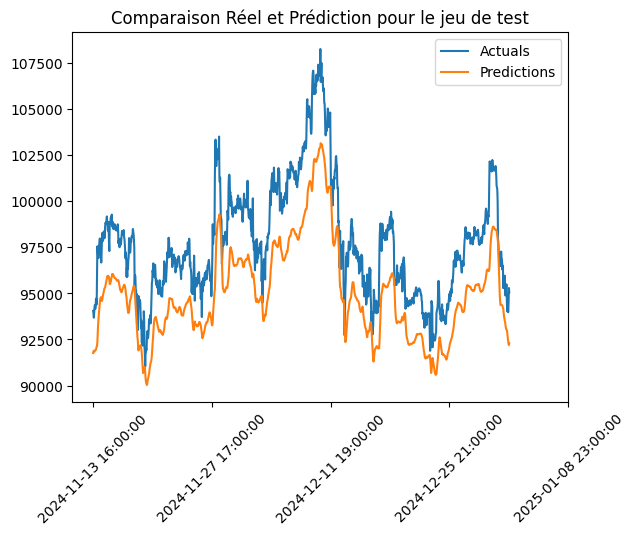

In [53]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train, full_model_name)

## TOUTES LES VARIABLES, en 1d (Daily)

#### Pre processing du dataframe dataset_v1_1d

In [20]:
def get_date(df):
    return df['date_utc'].copy()

def rearrange_data(df):
    df.dropna(inplace=True)
    #df.drop('Ignore', axis=1, inplace=True)
    df.drop('Open_time', axis=1, inplace=True)
    df.drop('date_utc', axis=1, inplace=True)
    df.drop('Close_time', axis=1, inplace=True)
    columns = ['Close_price'] + [col for col in df.columns if col != 'Close_price']
    df = df[columns]
    return df

def build_window_matrix_multi_var(df, window_size):
    """
    """
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    df_numpy = df_to_numpy(df)

    X = []
    y = []
    for i in range(len(df_numpy)-window_size):
        row = [a for a in df_numpy[i:i+window_size]]
        X.append(row)
        y.append(df_numpy[i+window_size][0])

    #Scaling de X
    X = np.array(X)
    X_reshape = X.reshape(X.shape[0], -1)
    X_scaled = scaler_features.fit_transform(X_reshape)
    X_scaled = np.array(X_scaled)
    X = X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])
    X = np.array(X)

    #Scaling de y
    y = np.array(y)
    y_reshape = y.reshape(-1, 1)
    y_scaled = scaler_target.fit_transform(y_reshape)
    y_scaled = np.array(y_scaled)
    y = y_scaled.reshape(y.shape[0],)

    return X.astype(np.float32), y.astype(np.float32), scaler_features, scaler_target

In [21]:
data_name = "dataset_v1_1d"
# is_one_var = False car toutes les variables
is_one_var = False
#On passe la window de 7 à 7*4=28 pour garder une semaine de fenêtre 
WINDOW_SIZE = 7

(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (393, 7, 29)
y_train : (393,)
X_val : (49, 7, 29)
y_val : (49,)
X_test : (50, 7, 29)
y_test : (50,)


#### Training du modèle All_variables-dataset_v1_1d-100

In [22]:
N_EPOCHS = 100
model_name = "All_variables"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

#main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

#### Analyse du modèle All_variables-dataset_v1_1d-100

In [23]:
def analyze(date, X, y, predictions):
    """
    """
    df_analyze = pd.concat([
                            pd.DataFrame(date), 
                            pd.DataFrame(X[:, WINDOW_SIZE-1, 0]), 
                            pd.DataFrame(y.reshape(-1)), 
                            pd.DataFrame(predictions)
                            ], axis=1)


    df_analyze.columns = ['Date', 'Actual N', 'Actual N+1', 'Predictions N+1']

    df_analyze_minuit = df_analyze[pd.to_datetime(df_analyze['Date']).dt.time == pd.Timestamp('00:00:00').time()]

    df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
    df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))
    
    cm = confusion_matrix(df_analyze_minuit['Actual UP or DOWN'], df_analyze_minuit['Predicted UP or DOWN'])
    print(cm)
    acc = cm[0][0] + cm[1][1]
    tot = cm.sum()
    print(f'Accuracy : {acc/tot*100}%')
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    
    return df_analyze_minuit, cm_df

def analyze_for_data(model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train):

    if is_train==1:
        date = date_train
        X = X_train
        y = y_train
    elif is_train==0:
        date = date_test
        X = X_test
        y = y_test
    else :
        date = date_val
        X = X_val
        y = y_val

    print(X.shape)
    pred = predict(model, X)
    print(X.reshape(X.shape[0], -1).shape)
    X_reshape = X.reshape(X.shape[0], -1)
    X_inv_scaled = inverse_scaler(scaler_features, X_reshape)
    X_inv_scaled = np.array(X_inv_scaled)
    X = X_inv_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])
    print(X.shape)
    y = inverse_scaler(scaler_target, [y])
    print(y.shape)
    predictions = inverse_scaler(scaler_target, pred)

    df_analyze, cm_df = analyze(date, X, y, predictions)
    print(f"#####{'TRAIN' if is_train==1 else 'TEST' if is_train==2 else 'VAL'}#####\n",df_analyze)
    print(f'######MATRICE DE CONFUSION#######\n {cm_df}')
    plot(df_analyze, model.name, is_train)

def main_analyze_model(is_train, model_name):
    model_name = model_name
    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    (date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var=False)

    analyze_for_data(loaded_model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train)

(393, 7, 29)
13/13 [==============================] - 1s 5ms/step
(393, 203)
(393, 7, 29)
(1, 393)
[[123  63]
 [ 34 173]]
Accuracy : 75.31806615776081%
#####TRAIN#####
            Date      Actual N    Actual N+1  Predictions N+1  \
0    2023-08-28  25826.019531  25792.099991     25979.986328   
1    2023-08-29  25792.099609  25759.950005     25905.601562   
2    2023-08-30  25759.949219  26255.000012     26142.824219   
3    2023-08-31  26255.001953  25910.500008     26152.904297   
4    2023-09-01  25910.500000  25901.610035     26092.597656   
..          ...           ...           ...              ...   
388  2024-09-19  65173.988281  65769.949649     66443.906250   
389  2024-09-20  65769.953125  65857.999951     66199.375000   
390  2024-09-21  65858.000000  65602.010252     66000.281250   
391  2024-09-22  65602.015625  63327.588998     65276.300781   
392  2024-09-23  63327.589844  60805.780854     63773.582031   

     Actual UP or DOWN  Predicted UP or DOWN  
0              

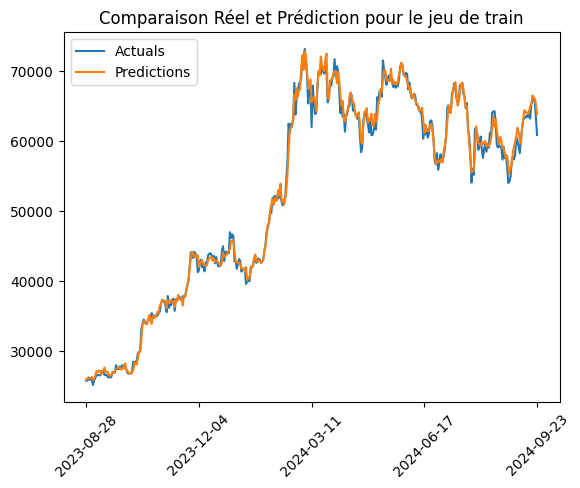

(49, 7, 29)
2/2 [==============================] - 1s 6ms/step
(49, 203)
(49, 7, 29)
(1, 49)
[[22  0]
 [27  0]]
Accuracy : 44.89795918367347%
#####TEST#####
           Date      Actual N    Actual N+1  Predictions N+1  \
0   2024-09-24  60805.781250  60649.279695     60723.886719   
1   2024-09-25  60649.277344  60752.708878     58653.789062   
2   2024-09-26  60752.710938  62085.999622     55485.746094   
3   2024-09-27  62086.000000  62058.000070     55573.785156   
4   2024-09-28  62058.000000  62819.909797     53554.417969   
5   2024-09-29  62819.910156  62223.999310     52913.082031   
6   2024-09-30  62224.000000  62160.490544     51100.101562   
7   2024-10-01  62160.492188  60636.019544     51364.136719   
8   2024-10-02  60636.019531  60326.390782     49154.941406   
9   2024-10-03  60326.390625  62540.001150     47965.613281   
10  2024-10-04  62540.000000  63206.220604     51146.382812   
11  2024-10-05  63206.222656  62870.020863     50957.265625   
12  2024-10-06  62870.0

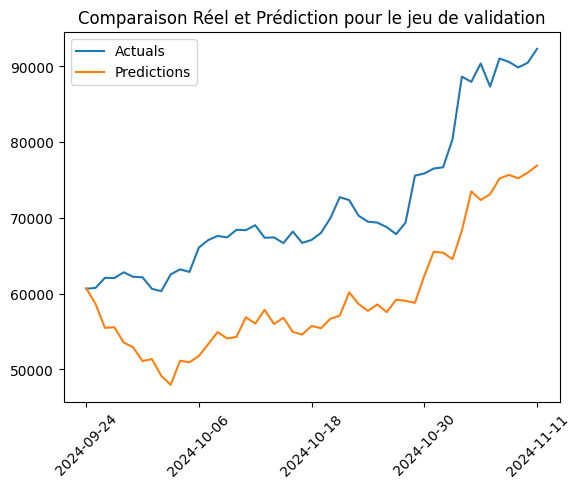

(50, 7, 29)
2/2 [==============================] - 1s 5ms/step
(50, 203)
(50, 7, 29)
(1, 50)
[[30  0]
 [28  0]]
Accuracy : 51.724137931034484%
#####VAL#####
           Date       Actual N     Actual N+1  Predictions N+1  \
0   2024-11-12   92310.789062   94286.558335     76486.273438   
1   2024-11-13   94286.554688   98317.118347     76539.515625   
2   2024-11-14   98317.117188   98891.998403     83151.320312   
3   2024-11-15   98891.992188   97672.402298     82389.007812   
4   2024-11-16   97672.398438   97900.037715     81410.765625   
5   2024-11-17   97900.031250   93010.012352     82806.976562   
6   2024-11-18   93010.007812   91965.160672     81255.718750   
7   2024-11-19   91965.164062   95863.109516     77863.007812   
8   2024-11-20   95863.109375   95643.977970     78951.460938   
9   2024-11-21   95643.976562   97459.998560     81821.523438   
10  2024-11-22   97459.992188   96407.989535     81859.664062   
11  2024-11-23   96407.984375   97185.181617     80563.265625 

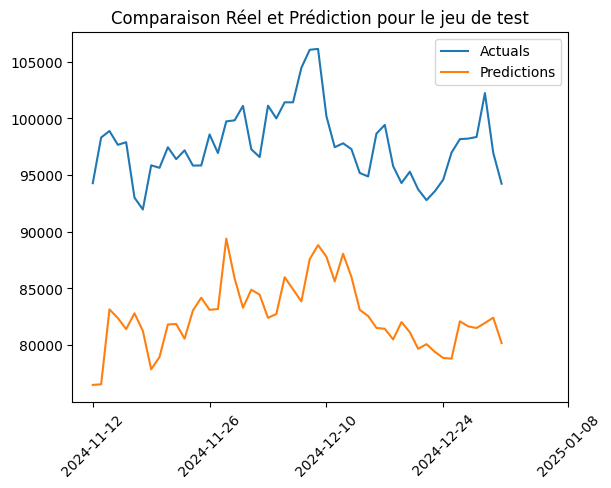

In [24]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train, full_model_name)

## TOUTES LES VARIABLES, en 6h (6 heures)

#### Pre processing du dataframe dataset_v1_6h

In [37]:
def get_date(df):
    return df['date_utc'].copy()

def rearrange_data(df):
    df.dropna(inplace=True)
    #df.drop('Ignore', axis=1, inplace=True)
    #df.drop('Open_time', axis=1, inplace=True)
    df.drop('date_utc', axis=1, inplace=True)
    #df.drop('Close_time', axis=1, inplace=True)
    columns = ['Close_price'] + [col for col in df.columns if col != 'Close_price']
    df = df[columns]
    return df

def build_window_matrix_multi_var(df, window_size):
    """
    """
    scaler_features = MinMaxScaler()
    scaler_target = MinMaxScaler()

    df_numpy = df_to_numpy(df)

    X = []
    y = []
    for i in range(len(df_numpy)-window_size):
        row = [a for a in df_numpy[i:i+window_size]]
        X.append(row)
        y.append(df_numpy[i+window_size][0])

    #Scaling de X
    X = np.array(X)
    X_reshape = X.reshape(X.shape[0], -1)
    X_scaled = scaler_features.fit_transform(X_reshape)
    X_scaled = np.array(X_scaled)
    X = X_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])
    X = np.array(X)

    #Scaling de y
    y = np.array(y)
    y_reshape = y.reshape(-1, 1)
    y_scaled = scaler_target.fit_transform(y_reshape)
    y_scaled = np.array(y_scaled)
    y = y_scaled.reshape(y.shape[0],)

    return X.astype(np.float32), y.astype(np.float32), scaler_features, scaler_target

In [33]:
data_name = "dataset_v1_6h"
# is_one_var = False car toutes les variables
is_one_var = False
#On passe la window de 7 à 7*4=28 pour garder une semaine de fenêtre 
WINDOW_SIZE = 7*4

(date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var)
print(f'X_train : {X_train.shape}')
print(f'y_train : {y_train.shape}')
print(f'X_val : {X_val.shape}')
print(f'y_val : {y_val.shape}')
print(f'X_test : {X_test.shape}')
print(f'y_test : {y_test.shape}')

X_train : (1576, 28, 33)
y_train : (1576,)
X_val : (197, 28, 33)
y_val : (197,)
X_test : (198, 28, 33)
y_test : (198,)


#### Training du modèle All_variables-dataset_v1_6h-100

In [38]:
N_EPOCHS = 50
model_name = "All_variables"
full_model_name = model_name+'-'+data_name+'-'+str(N_EPOCHS)

main_training_model(full_model_name, scaler_features, scaler_target, X_train, y_train, X_val, y_val, N_EPOCHS)

Epoch 1/50
49/50 [============================>.] - ETA: 0s - loss: 0.0120 - root_mean_squared_error: 0.1094

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 9s 140ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092 - val_loss: 0.0285 - val_root_mean_squared_error: 0.1688
Epoch 2/50
49/50 [============================>.] - ETA: 0s - loss: 5.4749e-04 - root_mean_squared_error: 0.0234

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 149ms/step - loss: 5.4801e-04 - root_mean_squared_error: 0.0234 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1488
Epoch 3/50
49/50 [============================>.] - ETA: 0s - loss: 4.0237e-04 - root_mean_squared_error: 0.0201

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 147ms/step - loss: 4.0304e-04 - root_mean_squared_error: 0.0201 - val_loss: 0.0176 - val_root_mean_squared_error: 0.1329
Epoch 4/50
49/50 [============================>.] - ETA: 0s - loss: 3.2845e-04 - root_mean_squared_error: 0.0181

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 6s 131ms/step - loss: 3.2891e-04 - root_mean_squared_error: 0.0181 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1162
Epoch 5/50
49/50 [============================>.] - ETA: 0s - loss: 2.9374e-04 - root_mean_squared_error: 0.0171

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 150ms/step - loss: 2.9405e-04 - root_mean_squared_error: 0.0171 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 6/50
49/50 [============================>.] - ETA: 0s - loss: 2.7947e-04 - root_mean_squared_error: 0.0167

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 6s 128ms/step - loss: 2.7827e-04 - root_mean_squared_error: 0.0167 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1078
Epoch 7/50
49/50 [============================>.] - ETA: 0s - loss: 2.2133e-04 - root_mean_squared_error: 0.0149

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 151ms/step - loss: 2.2111e-04 - root_mean_squared_error: 0.0149 - val_loss: 0.0092 - val_root_mean_squared_error: 0.0958
Epoch 8/50
49/50 [============================>.] - ETA: 0s - loss: 1.9579e-04 - root_mean_squared_error: 0.0140

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 6s 130ms/step - loss: 1.9566e-04 - root_mean_squared_error: 0.0140 - val_loss: 0.0083 - val_root_mean_squared_error: 0.0913
Epoch 9/50
49/50 [============================>.] - ETA: 0s - loss: 1.9184e-04 - root_mean_squared_error: 0.0139

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 147ms/step - loss: 1.9350e-04 - root_mean_squared_error: 0.0139 - val_loss: 0.0076 - val_root_mean_squared_error: 0.0871
Epoch 10/50
49/50 [============================>.] - ETA: 0s - loss: 1.8345e-04 - root_mean_squared_error: 0.0135

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 146ms/step - loss: 1.8301e-04 - root_mean_squared_error: 0.0135 - val_loss: 0.0086 - val_root_mean_squared_error: 0.0927
Epoch 11/50
50/50 [==============================] - ETA: 0s - loss: 1.5965e-04 - root_mean_squared_error: 0.0126

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 136ms/step - loss: 1.5965e-04 - root_mean_squared_error: 0.0126 - val_loss: 0.0078 - val_root_mean_squared_error: 0.0884
Epoch 12/50
50/50 [==============================] - ETA: 0s - loss: 1.5088e-04 - root_mean_squared_error: 0.0123

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 152ms/step - loss: 1.5088e-04 - root_mean_squared_error: 0.0123 - val_loss: 0.0059 - val_root_mean_squared_error: 0.0766
Epoch 13/50
50/50 [==============================] - 2s 30ms/step - loss: 1.7082e-04 - root_mean_squared_error: 0.0131 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0826
Epoch 14/50
49/50 [============================>.] - ETA: 0s - loss: 1.3293e-04 - root_mean_squared_error: 0.0115

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 6s 128ms/step - loss: 1.3312e-04 - root_mean_squared_error: 0.0115 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 15/50
50/50 [==============================] - 2s 31ms/step - loss: 1.4503e-04 - root_mean_squared_error: 0.0120 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0759
Epoch 16/50
50/50 [==============================] - 2s 31ms/step - loss: 1.3813e-04 - root_mean_squared_error: 0.0118 - val_loss: 0.0071 - val_root_mean_squared_error: 0.0842
Epoch 17/50
49/50 [============================>.] - ETA: 0s - loss: 1.2596e-04 - root_mean_squared_error: 0.0112

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 148ms/step - loss: 1.2549e-04 - root_mean_squared_error: 0.0112 - val_loss: 0.0068 - val_root_mean_squared_error: 0.0823
Epoch 18/50
49/50 [============================>.] - ETA: 0s - loss: 1.2324e-04 - root_mean_squared_error: 0.0111

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 6s 125ms/step - loss: 1.2290e-04 - root_mean_squared_error: 0.0111 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0752
Epoch 19/50
49/50 [============================>.] - ETA: 0s - loss: 1.0998e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 145ms/step - loss: 1.0975e-04 - root_mean_squared_error: 0.0105 - val_loss: 0.0052 - val_root_mean_squared_error: 0.0723
Epoch 20/50
49/50 [============================>.] - ETA: 0s - loss: 1.0961e-04 - root_mean_squared_error: 0.0105

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 135ms/step - loss: 1.0937e-04 - root_mean_squared_error: 0.0105 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0761
Epoch 21/50
50/50 [==============================] - 2s 31ms/step - loss: 1.1378e-04 - root_mean_squared_error: 0.0107 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0665
Epoch 22/50
50/50 [==============================] - 2s 30ms/step - loss: 1.3497e-04 - root_mean_squared_error: 0.0116 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0683
Epoch 23/50
50/50 [==============================] - 2s 30ms/step - loss: 1.1991e-04 - root_mean_squared_error: 0.0110 - val_loss: 0.0058 - val_root_mean_squared_error: 0.0763
Epoch 24/50
50/50 [==============================] - 2s 32ms/step - loss: 1.3673e-04 - root_mean_squared_error: 0.0117 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609
Epoch 25/50
50/50 [==============================] - 2s 31ms/step - loss: 1.4744e-04 - root_mean_squared_error: 0.0121 - val_loss: 

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 8s 153ms/step - loss: 1.0830e-04 - root_mean_squared_error: 0.0104 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0694
Epoch 29/50
50/50 [==============================] - 2s 31ms/step - loss: 1.2688e-04 - root_mean_squared_error: 0.0113 - val_loss: 0.0057 - val_root_mean_squared_error: 0.0758
Epoch 30/50
49/50 [============================>.] - ETA: 0s - loss: 1.0300e-04 - root_mean_squared_error: 0.0101

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 150ms/step - loss: 1.0285e-04 - root_mean_squared_error: 0.0101 - val_loss: 0.0047 - val_root_mean_squared_error: 0.0688
Epoch 31/50
50/50 [==============================] - 2s 30ms/step - loss: 1.0381e-04 - root_mean_squared_error: 0.0102 - val_loss: 0.0049 - val_root_mean_squared_error: 0.0698
Epoch 32/50
49/50 [============================>.] - ETA: 0s - loss: 9.0498e-05 - root_mean_squared_error: 0.0095

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 6s 130ms/step - loss: 9.1443e-05 - root_mean_squared_error: 0.0096 - val_loss: 0.0044 - val_root_mean_squared_error: 0.0664
Epoch 33/50
50/50 [==============================] - 2s 30ms/step - loss: 1.1446e-04 - root_mean_squared_error: 0.0107 - val_loss: 0.0046 - val_root_mean_squared_error: 0.0679
Epoch 34/50
49/50 [============================>.] - ETA: 0s - loss: 8.4446e-05 - root_mean_squared_error: 0.0092

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 150ms/step - loss: 8.5206e-05 - root_mean_squared_error: 0.0092 - val_loss: 0.0042 - val_root_mean_squared_error: 0.0647
Epoch 35/50
50/50 [==============================] - 2s 30ms/step - loss: 8.9879e-05 - root_mean_squared_error: 0.0095 - val_loss: 0.0043 - val_root_mean_squared_error: 0.0659
Epoch 36/50
50/50 [==============================] - 1s 30ms/step - loss: 1.1315e-04 - root_mean_squared_error: 0.0106 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0597
Epoch 37/50
50/50 [==============================] - 2s 31ms/step - loss: 1.0963e-04 - root_mean_squared_error: 0.0105 - val_loss: 0.0048 - val_root_mean_squared_error: 0.0692
Epoch 38/50
50/50 [==============================] - 2s 30ms/step - loss: 1.0345e-04 - root_mean_squared_error: 0.0102 - val_loss: 0.0045 - val_root_mean_squared_error: 0.0671
Epoch 39/50
50/50 [==============================] - 2s 30ms/step - loss: 9.2651e-05 - root_mean_squared_error: 0.0096 - val_loss: 

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 6s 130ms/step - loss: 8.4558e-05 - root_mean_squared_error: 0.0092 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0578
Epoch 45/50
49/50 [============================>.] - ETA: 0s - loss: 8.1871e-05 - root_mean_squared_error: 0.0090

INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


INFO:tensorflow:Assets written to: /home/alexander.lunel/Private/ML/Projet_ml/src/model/models/All_variables-dataset_v1_6h-50/assets


50/50 [==============================] - 7s 151ms/step - loss: 8.2582e-05 - root_mean_squared_error: 0.0091 - val_loss: 0.0033 - val_root_mean_squared_error: 0.0570
Epoch 46/50
50/50 [==============================] - 2s 31ms/step - loss: 9.7208e-05 - root_mean_squared_error: 0.0099 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 47/50
50/50 [==============================] - 1s 30ms/step - loss: 8.8952e-05 - root_mean_squared_error: 0.0094 - val_loss: 0.0041 - val_root_mean_squared_error: 0.0642
Epoch 48/50
50/50 [==============================] - 2s 30ms/step - loss: 8.7746e-05 - root_mean_squared_error: 0.0094 - val_loss: 0.0039 - val_root_mean_squared_error: 0.0623
Epoch 49/50
50/50 [==============================] - 2s 31ms/step - loss: 1.0506e-04 - root_mean_squared_error: 0.0102 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0569
Epoch 50/50
50/50 [==============================] - 2s 30ms/step - loss: 1.2867e-04 - root_mean_squared_error: 0.0113 - val_loss: 

In [35]:
def analyze(date, X, y, predictions):
    """
    """
    df_analyze = pd.concat([
                            pd.DataFrame(date), 
                            pd.DataFrame(X[:, WINDOW_SIZE-1, 0]), 
                            pd.DataFrame(y.reshape(-1)), 
                            pd.DataFrame(predictions)
                            ], axis=1)


    df_analyze.columns = ['Date', 'Actual N', 'Actual N+1', 'Predictions N+1']
    df_analyze_minuit = df_analyze
    #df_analyze_minuit = df_analyze[pd.to_datetime(df_analyze['Date']).dt.time == pd.Timestamp('00:00:00').time()]

    df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
    df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))
    
    cm = confusion_matrix(df_analyze_minuit['Actual UP or DOWN'], df_analyze_minuit['Predicted UP or DOWN'])
    print(cm)
    acc = cm[0][0] + cm[1][1]
    tot = cm.sum()
    print(f'Accuracy : {acc/tot*100}%')
    cm_df = pd.DataFrame(cm, index=['Actual DOWN', 'Actual UP'], columns=['Predicted DOWN', 'Predicted UP'])
    
    return df_analyze_minuit, cm_df

def analyze_for_data(model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train):

    if is_train==1:
        date = date_train
        X = X_train
        y = y_train
    elif is_train==0:
        date = date_test
        X = X_test
        y = y_test
    else :
        date = date_val
        X = X_val
        y = y_val

    print(X.shape)
    pred = predict(model, X)
    print(X.reshape(X.shape[0], -1).shape)
    X_reshape = X.reshape(X.shape[0], -1)
    X_inv_scaled = inverse_scaler(scaler_features, X_reshape)
    X_inv_scaled = np.array(X_inv_scaled)
    X = X_inv_scaled.reshape(X.shape[0], X.shape[1], X.shape[2])
    print(X.shape)
    y = inverse_scaler(scaler_target, [y])
    print(y.shape)
    predictions = inverse_scaler(scaler_target, pred)

    df_analyze, cm_df = analyze(date, X, y, predictions)
    print(f"#####{'TRAIN' if is_train==1 else 'TEST' if is_train==2 else 'VAL'}#####\n",df_analyze)
    print(f'######MATRICE DE CONFUSION#######\n {cm_df}')
    plot(df_analyze, model.name, is_train)

def main_analyze_model(is_train, model_name):
    model_name = model_name
    data_name = model_name.split('-')[1]
    loaded_model = load(model_name)

    (date_train, X_train, y_train, date_val, X_val, y_val, date_test, X_test, y_test), scaler_features, scaler_target = main_pre_processing(data_name, is_one_var=False)

    analyze_for_data(loaded_model, scaler_features, scaler_target, date_train, X_train, y_train, date_test, X_test, y_test, date_val, X_val, y_val, is_train)

(1576, 28, 33)
50/50 [==============================] - 1s 9ms/step
(1576, 924)
(1576, 28, 33)
(1, 1576)
[[104  84]
 [ 59 147]]
Accuracy : 63.70558375634518%
#####TRAIN#####
                      Date      Actual N    Actual N+1  Predictions N+1  \
0     2023-08-28 00:00:00  25934.439453  25892.490004     25876.007812   
4     2023-08-29 00:00:00  25733.310547  25783.679993     25734.175781   
8     2023-08-30 00:00:00  25746.548828  25733.290004     26035.109375   
12    2023-08-31 00:00:00  25788.919922  25708.600005     25702.458984   
16    2023-09-01 00:00:00  26239.429688  25839.510008     25937.142578   
...                   ...           ...           ...              ...   
1556  2024-09-20 00:00:00  65354.578125  65437.349336     65219.937500   
1560  2024-09-21 00:00:00  65953.804688  65798.009479     66216.484375   
1564  2024-09-22 00:00:00  65594.007812  65691.918964     65929.218750   
1568  2024-09-23 00:00:00  64525.992188  63819.438916     64253.105469   
1572  2024-

/tmp/ipykernel_3806110/3862336380.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
/tmp/ipykernel_3806110/3862336380.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))


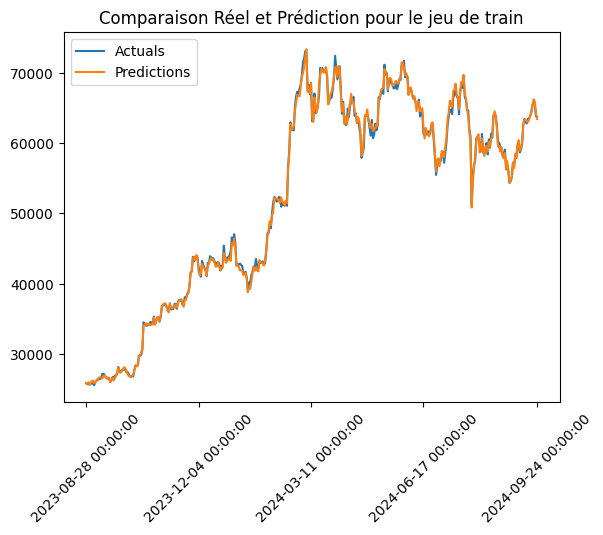

(197, 28, 33)
7/7 [==============================] - 1s 9ms/step
(197, 924)
(197, 28, 33)
(1, 197)
[[25  1]
 [23  1]]
Accuracy : 52.0%
#####TEST#####
                     Date      Actual N    Actual N+1  Predictions N+1  \
0    2024-09-25 00:00:00  61489.710938  61164.010327     61481.906250   
4    2024-09-26 00:00:00  61176.011719  60764.740804     60638.644531   
8    2024-09-27 00:00:00  61224.339844  61449.839490     59963.906250   
12   2024-09-28 00:00:00  62149.472656  62179.999222     61563.109375   
16   2024-09-29 00:00:00  61938.507812  62101.919096     62296.386719   
20   2024-09-30 00:00:00  63380.011719  63135.439639     62020.027344   
24   2024-10-01 00:00:00  62517.351562  62624.010765     60719.695312   
28   2024-10-02 00:00:00  62524.093750  62199.999631     61780.871094   
32   2024-10-03 00:00:00  60941.484375  61262.000062     59697.093750   
36   2024-10-04 00:00:00  60600.000000  61174.869445     58582.925781   
40   2024-10-05 00:00:00  62778.011719  62936.

/tmp/ipykernel_3806110/3862336380.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
/tmp/ipykernel_3806110/3862336380.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))


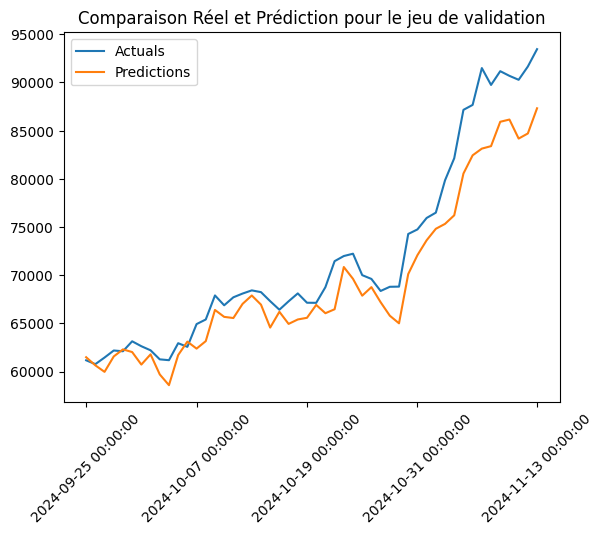

(198, 28, 33)
7/7 [==============================] - 1s 11ms/step
(198, 924)
(198, 28, 33)
(1, 198)
[[32  0]
 [24  0]]
Accuracy : 57.14285714285714%
#####VAL#####
                     Date       Actual N     Actual N+1  Predictions N+1  \
3    2024-11-14 00:00:00   97328.000000   97974.989616     88427.476562   
7    2024-11-15 00:00:00   98790.968750   98870.379724     91571.687500   
11   2024-11-16 00:00:00   98755.148438   98429.987887     92642.945312   
15   2024-11-17 00:00:00   98264.437500   97280.030605     93728.750000   
19   2024-11-18 00:00:00   98082.695312   98188.088457     90123.359375   
23   2024-11-19 00:00:00   94647.960938   92356.847619     87162.281250   
27   2024-11-20 00:00:00   92768.015625   93367.989789     87559.859375   
31   2024-11-21 00:00:00   95443.429688   95452.007909     88572.289062   
35   2024-11-22 00:00:00   96153.859375   97237.909497     89785.484375   
39   2024-11-23 00:00:00   97102.320312   96267.990257     91147.828125   
43   2024-1

/tmp/ipykernel_3806110/3862336380.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Actual UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Actual N+1'] > df_analyze_minuit['Actual N']).astype(int))
/tmp/ipykernel_3806110/3862336380.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analyze_minuit['Predicted UP or DOWN'] = pd.DataFrame((df_analyze_minuit['Predictions N+1'] > df_analyze_minuit['Actual N']).astype(int))


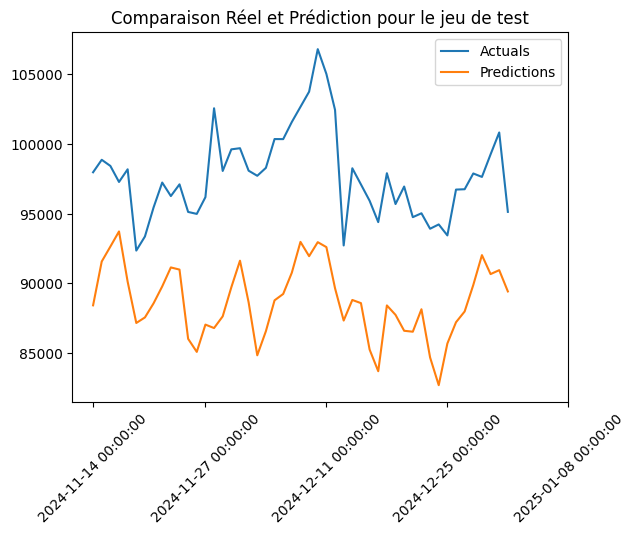

In [36]:
"is_train : 1 pour Train, 0 pour Test , autre pour val"
for is_train in (1, 2, 0):
    main_analyze_model(is_train, full_model_name)